In [165]:
'''
typedef struct {
    uint32_t            magic;
    uint32_t            id;
    uint32_t            timestamp;
    uint8_t             gps_flags;
    uint8_t             gps_sat;
    float               gps_lat;
    float               gps_long;
    uint16_t            gps_alt;
    uint8_t             gps_hour;
    uint8_t             gps_min;
    uint8_t             gps_sec;
    uint16_t            num_energy_data;
} hdr_t;

typedef struct {
    uint8_t         info;
    uint32_t        timestamp_us;
    float           energy;
} energy_data_t;
'''

import numpy as np

hdr_t = np.dtype([
    ('magic', 'u4'),
    ('id', 'u4'),
    ('timestamp', 'u4'),
    ('gps_flags', 'u1'),
    ('gps_sat', 'u1'),
    ('gps_lat', 'f4'),
    ('gps_long', 'f4'),
    ('gps_alt', 'u2'),
    ('gps_hour', 'u1'),
    ('gps_min', 'u1'),
    ('gps_sec', 'u1'),
    ('num_energy_data', 'u2'),
], align=True)

energy_data_t = np.dtype([
    ('info', 'u1'),
    ('timestamp_us', 'u4'),
    ('energy', 'f4'),
], align=True)

In [166]:
def read_rt_dat_file(filename):
    ret_dtype = np.dtype([
        ('time', 'u4'),
        ('time_us', 'u4'),
        ('energy', 'f4'),
        ('info', 'u1'),
        ('gps_lat', 'f4'),
        ('gps_long', 'f4'),
        ('gps_alt', 'u2')
    ])
    
    ret = np.zeros(0, dtype=ret_dtype)
    pieces = []

    with open(filename, 'r') as f:
        while True:
            try:
                hdr = np.fromfile(f, dtype=hdr_t, count=1)[0]
            except IndexError:
                break
            if hdr['magic'] != 0xaaaabbbb:
                raise Exception('corrupted data, magic mismatch')
                
            energy_data = np.fromfile(f, dtype=energy_data_t, count=hdr['num_energy_data'])
            piece = np.zeros(len(energy_data), dtype=ret_dtype)
            piece['time'] = hdr['timestamp']
            piece['time_us'] = energy_data['timestamp_us']
            piece['energy'] = energy_data['energy']
            piece['info'] = energy_data['info']
            piece['gps_lat'] = hdr['gps_lat']
            piece['gps_long'] = hdr['gps_long']
            piece['gps_alt'] = hdr['gps_alt']
            pieces.append(piece)
    return np.concatenate(pieces)

In [168]:
d = read_rt_dat_file('/storage/experiments/2020/05_namesti/data.dat')
#d = read_rt_dat_file('/storage/experiments/2020/0428_bourka_chotoviny/rt56#2/data.dat')
#d = read_rt_dat_file('/storage/experiments/2020/0504_bourka_chotoviny/rt56#2/data.dat')

print(d[0],d[-1])
d['time']

(1588787122, 81050, 19.276146, 0, 0., 2.9076e-41, 0) (1588793653, 955170, 37.272602, 1, 0., 2.9076e-41, 0)


array([1588787122, 1588787122, 1588787122, ..., 1588793653, 1588793653,
       1588793653], dtype=uint32)

In [169]:
d['time'].max()

1588793653

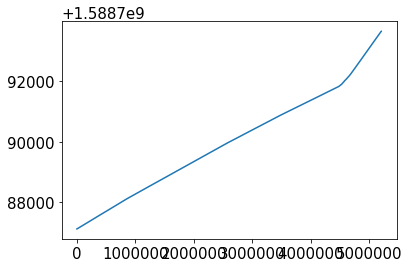

In [170]:
from matplotlib import pyplot as plt
plt.plot(d['time'])

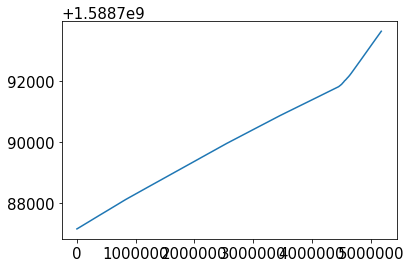

In [171]:
plt.plot(d[25338:]['time'])

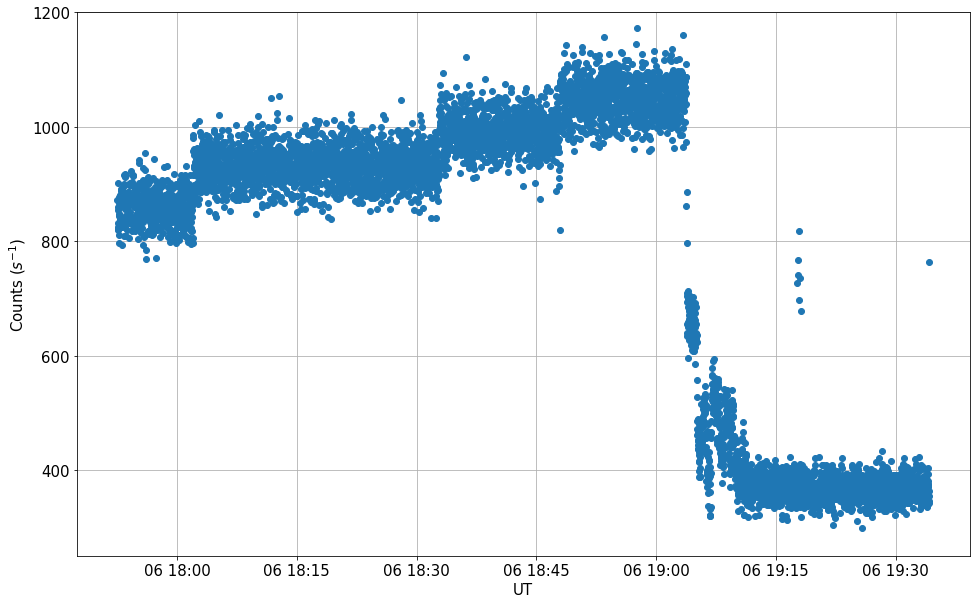

In [183]:
import matplotlib.dates as md
import matplotlib

tmin = 1588787553
tmax = 1588793653

#tmin = 1588613100
#tmax = 1588618290

emin = 1
emax = 1300

nhits, time = np.histogram(d[(d['energy'] > emin) & (d['energy'] < emax)]['time'], tmax-tmin, [tmin, tmax])

plt.figure(figsize=(16, 10))
matplotlib.rcParams.update({'font.size': 15})

plt.ylabel('Counts ($s^{-1}$)')
plt.xlabel('UT')
plt.plot_date(md.epoch2num(time[:-1]), nhits)
plt.ylim(250,1200)
#plt.yscale('log')
plt.grid()

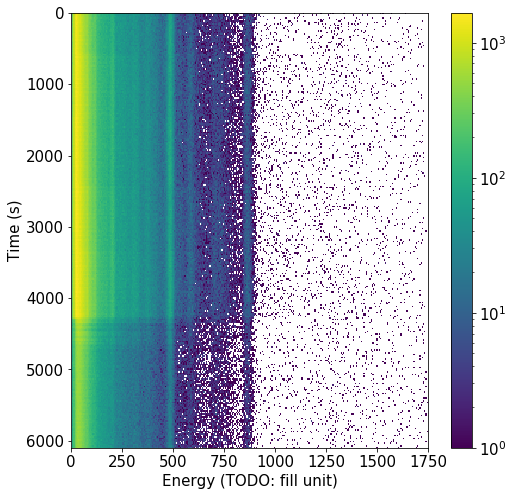

In [198]:
from matplotlib.colors import LogNorm

im, _1, _2 = np.histogram2d(d['time'], d['energy'], [300, 300], [[tmin, tmax], [0, 1750]])

plt.figure(figsize=(8, 8))
plt.ylabel('Time (s)')
plt.xlabel('Energy (TODO: fill unit)')
#plt.imshow(im, extent=[0, 1750, 0, tmax-tmin], aspect='auto')
plt.imshow(im, extent=[0, 1750, tmax-tmin, 0], aspect='auto', norm=LogNorm())#, cmap='prism')
plt.colorbar()